# Exercice : krigeage de la fonction Ishigami

On considère la fonction 
$$
g(X_1,X_2,X_3) = \sin(X_1)+a \sin (X_2)^2 + b X_3^4 \sin(X_1)
$$
pour tout $X_1,X_2,X_3\in[-\pi,\pi]$ où $a=7$ et $b=0.1$. 

On suppose que les variables sont indépendantes et suivent la loi uniforme entre $-\pi$ et $\pi$.

L'objectif de cet exercice est de créer un métamodèle de krigeage de cette fonction. Puis nous allons réaliser l'étude de sensibilité de la fonction, en utilisant le métamodèle.

*Questions*

Définition du modèle
* Définir la fonction `g` associée à la fonction.
* Définir la distribution `distribution` au vecteur aléatoire en entrée.



In [22]:
import seaborn as sns
import pandas as pd 
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt 

In [23]:
# Ishigami parameters
a = 7.
b = 0.1
# Random variable
X1 = ot.Uniform(-np.pi, np.pi)
# Composite distribution
my_distribution = ot.ComposedDistribution([X1]*3)
# Random Vector 
X_RV = ot.RandomVector(my_distribution)

In [24]:
# Symbolic function
ishigami_model = ot.SymbolicFunction(['x1', 'x2', 'x3', 'a', 'b'], \
                        ['sin(x1) + a * sin(x2)^2 \
                        + b * x3^4 * sin(x1)'])
# Parametric function
g = ot.ParametricFunction(ishigami_model, [3, 4], [7., 0.1])

In [25]:
Y = ot.CompositeRandomVector(g, X_RV)

Apprentissage
* Créer un échantillon `X_train` de taille 20 en entrée du modèle et évaluer les sorties correspondantes `Y_train`. 
* Dessiner l'histogramme des sorties. 
* Utiliser la classe `SquaredExponential` pour définir un modèle exponentiel carré. 
* Créer un métamodèle de krigeage avec la classe `KrigingAlgorithm`. Vous utiliserez une base de type `ConstantBasisFactory`.



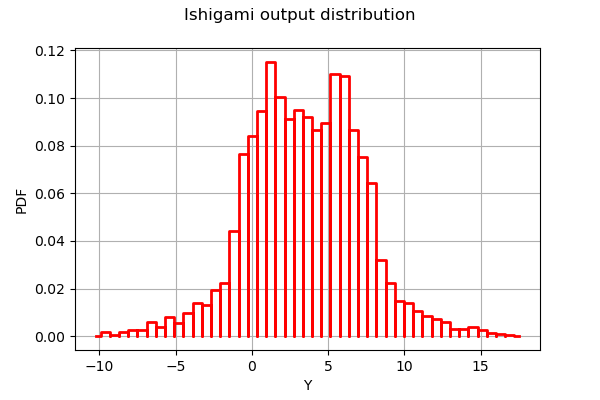

In [26]:
histo = ot.HistogramFactory().build(g(my_distribution.getSample(10000))).drawPDF()
histo.setXTitle("Y")
histo.setTitle("Ishigami output distribution")
histo.setLegends([""])
histo

## PEX contruction

In [27]:
train_size = 200
X_train_cmc = my_distribution.getSample(train_size)
Y_train_cmc = g(X_train_cmc)

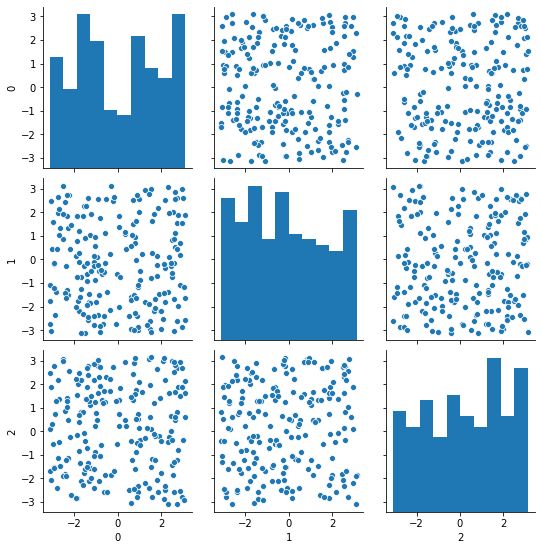

In [28]:
sns.pairplot(data=pd.DataFrame(np.array(X_train_cmc)));

In [29]:
# Random LHS
lhs = ot.LHSExperiment(my_distribution, train_size)
lhs.setAlwaysShuffle(True) # randomized
X_train_lhs = lhs.generate()
Y_train_lhs = g(X_train_lhs)

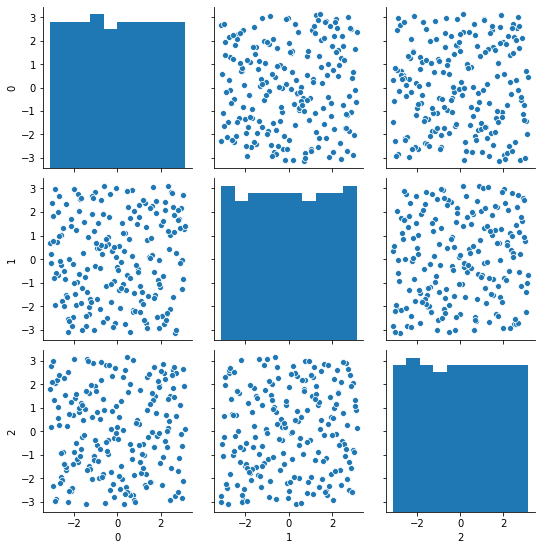

In [30]:
sns.pairplot(data=pd.DataFrame(np.array(X_train_lhs)));

In [31]:
# Sobol low discrepency experiment
sobol_doe = ot.LowDiscrepancyExperiment(ot.SobolSequence(), my_distribution, train_size)
X_train_sobol = sobol_doe.generate()
Y_train_sobol = g(X_train_sobol)

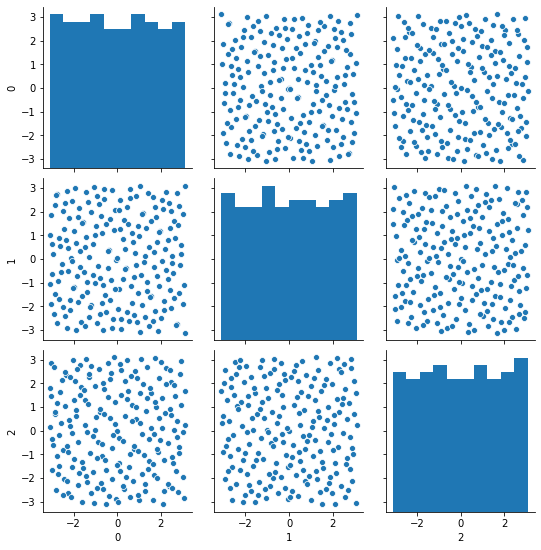

In [32]:
sns.pairplot(data=pd.DataFrame(np.array(X_train_sobol)));

In [33]:
# Random LHS
lhs_opt = ot.LHSExperiment(my_distribution, train_size)
lhs_opt.setAlwaysShuffle(True) # randomized
# Defining space fillings
spaceFilling_crit = ot.SpaceFillingC2()
# RandomBruteForce MonteCarlo with N designs (LHS with C2 optimization)
N = 10000
optimalLHSAlgorithm = ot.MonteCarloLHS(lhs_opt, N, spaceFilling_crit)
X_train_lhs_opt = lhs_opt.generate()
Y_train_lhs_opt = g(X_train_lhs_opt)

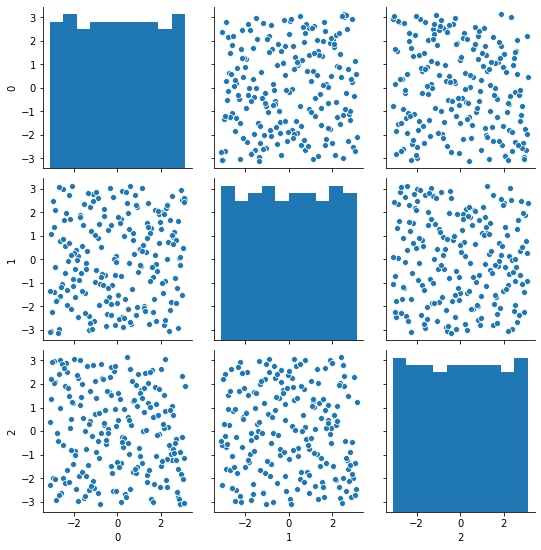

In [34]:
sns.pairplot(data=pd.DataFrame(np.array(X_train_lhs_opt)));

## Kriging construction and validation 

In [35]:
dimension = my_distribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])
#covarianceModel = ot.MaternModel([1.]*dimension, 2.5)
algo = ot.KrigingAlgorithm(X_train_cmc, Y_train_cmc, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

Validation
* Créer un échantillon `X_test` de taille 100 en entrée du modèle et évaluer les sorties correspondantes `Y_test`. 
* Utiliser la classe `MetaModelValidation` pour valider le métamodèle. 
* Quel est la valeur du coefficient de prédictivité ? 
* La qualité est-elle suffisante pour utiliser le métamodèle ? Quels paramètres peut-on changer ?
* Améliorez la qualité du métamodèle jusqu'à ce que la qualité soit suffisante, puis passez à la question suivante.

In [36]:
test_size = 1000
X_test = my_distribution.getSample(test_size)
Y_test = g(X_test)

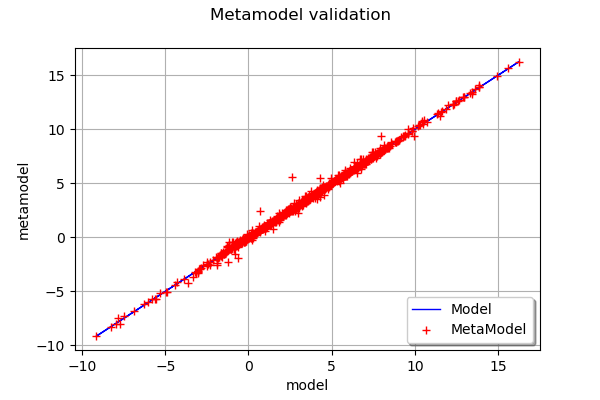

In [37]:
val = ot.MetaModelValidation(X_test, Y_test, krigeageMM)
graph = val.drawValidation()
graph

In [38]:
val.computePredictivityFactor()

0.9969562971159162

Résultats : 

DOE size : 80 points | Covariance model : SquaredExponential 

- CMC: Q2 = 0.91
- random LHS: Q2 = 0.90
- Sobol LD: Q2 = 0.90
- optimized LHS: Q2 = 0.85

DOE size : 50 points | Covariance model : SquaredExponential 

- CMC: Q2 = 0.78
- random LHS: Q2 = 0.71
- Sobol LD: Q2 = 0.47
- optimized LHS: Q2 = 0.60

DOE size : 20 points | Covariance model : SquaredExponential 

- CMC: Q2 = 0.28
- random LHS: Q2 = 0.17
- Sobol LD: Q2 = 0.01
- optimized LHS: Q2 = 0.11

**Les résulats des PEX "plus performants" sont moins bons, pourquoi ?"**

Analyse de sensibilité
* Utiliser la classe `SobolSimulationAlgorithm` pour estimer les indices de Sobol' du métamodèle. 
* Afficher les indices de Sobol'. 
* Analyser les indices de Sobol' : identifier les variables les plus influentes et les interactions.


**Pourquoi avions nous utilisé la classe SaltelliSensitivityAlgorithm pendant le cours sur l'AS ?**

In [67]:
estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True)
algo = ot.SobolSimulationAlgorithm(my_distribution, krigeageMM, estimator)
algo.setMaximumOuterSampling(25) # number of iterations
algo.setBlockSize(100) # size of Sobol experiment at each iteration
algo.setBatchSize(4) # number of points evaluated simultaneously
algo.setIndexQuantileLevel(0.05) # alpha
algo.setIndexQuantileEpsilon(1e-2) # epsilon
algo.run()
sobol_result = algo.getResult()

In [70]:
fo_sobol_indices = sobol_result.getFirstOrderIndicesEstimate()
fo_sobol_indices

class=Point name=Unnamed dimension=3 values=[0.334527,0.463883,-0.00337236]

In [71]:
to_sobol_indices = sobol_result.getTotalOrderIndicesEstimate()
to_sobol_indices

class=Point name=Unnamed dimension=3 values=[0.551964,0.460053,0.212448]

In [73]:
def plotSobolSimulationResult(sobolSimulationResult,input_names,alpha=0.05):
    fo = sobolSimulationResult.getFirstOrderIndicesEstimate()
    to = sobolSimulationResult.getTotalOrderIndicesEstimate()
    dist_fo = sobolSimulationResult.getFirstOrderIndicesDistribution()
    dist_to = sobolSimulationResult.getTotalOrderIndicesDistribution()
    dim = dist_to.getDimension()
    graph = ot.Graph("Sobol' sensivity indices","Inputs","Sensivity indices",True,"topright")
    # Indices
    curve = ot.Cloud(range(dim),fo)
    curve.setColor("red")
    curve.setLegend("First order")
    graph.add(curve)
    curve = ot.Cloud(range(dim),to)
    curve.setColor("blue")
    curve.setLegend("Total order")
    graph.add(curve)
    # Labels
    x = ot.Point(range(dim)) + ot.Point([0.1]*dim)
    text = ot.Text(x, to, input_names)
    text.setColor("black")
    graph.add(text)
    # Error bars
    for i in range(dim):
        dist_fo_i = dist_fo.getMarginal(i)
        dist_to_i = dist_to.getMarginal(i)
        fo_ci = dist_fo_i.computeBilateralConfidenceInterval(1-alpha)
        to_ci = dist_to_i.computeBilateralConfidenceInterval(1-alpha)
        fo_a = fo_ci.getLowerBound()[0]
        fo_b = fo_ci.getUpperBound()[0]
        to_a = to_ci.getLowerBound()[0]
        to_b = to_ci.getUpperBound()[0]
        curve = ot.Curve([i,i],[fo_a,fo_b])
        curve.setColor("red")
        graph.add(curve)
        curve = ot.Curve([i,i],[to_a,to_b])
        curve.setColor("blue")
        graph.add(curve)
    return graph

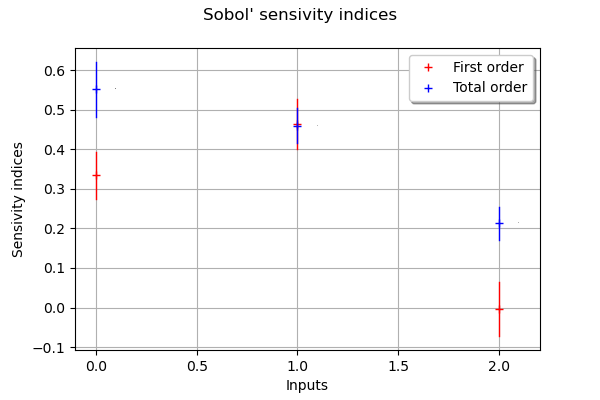

In [74]:
plotSobolSimulationResult(sobol_result, ['X1', 'X2', 'X3'])

On considère la fonction 
$$
g(X_0,X_1,X_2) = \sin(X_0)+a \sin (X_1)^2 + b X_2^4 \sin(X_0)
$$

Interprétation des indices de sensibilité : 

- La variable X1 a ses indices du 1er ordre et totaux égaux : la variable n'a aucune interaction avec les autres.
- Les variables X0 et X2 on des indices totaux supérieurs au 1er ordres : elles interagissent. 
- La variable X2 a un indice du 1er ordre nul, elle n'agit uniquement en interaction avec la variable X0. 